In [1]:
import json
import pandas as pd
import glob
import os
import numpy as np
from plotnine import *

In [2]:
result_files_AC = glob.glob(
    "../../inference_result/facebook/opt-1.3b/AudioCaps/excludes_prompt_magic/evaluation/test_performance/*.csv"
)

res_AC = [pd.read_csv(file) for file in result_files_AC]
res_AC = pd.concat(res_AC).sort_values("Mean_NLG_M")
res_AC

,Dataset,Model,Mean_NLG_M,Bleu_1,Bleu_2,Bleu_3,Bleu_4,METEOR,ROUGE_L,CIDEr,SPICE,SPIDEr
0,AudioCaps,Baseline_LM_only,0.047,0.188,0.011,0.000,0.000,0.041,0.178,0.001,0.000,0.000
0,AudioCaps,MAGIC_AudioCLIP,0.047,0.188,0.011,0.000,0.000,0.041,0.178,0.001,0.000,0.000
0,AudioCaps,MAGIC_LAION,0.068,0.214,0.056,0.019,0.000,0.055,0.203,0.014,0.027,0.020
0,AudioCaps,AudioCLIP_AudioSet+ChatGPT_KW,0.072,0.251,0.062,0.007,0.000,0.074,0.210,0.011,0.017,0.014
0,AudioCaps,MAGIC_WavCaps,0.073,0.223,0.070,0.027,0.000,0.059,0.207,0.025,0.024,0.024
0,AudioCaps,MAGIC_AudioCLIP_AudioSet+ChatGPT_KW,0.075,0.260,0.067,0.007,0.000,0.076,0.214,0.012,0.020,0.016
0,AudioCaps,AudioCLIP_AudioSet_KW,0.094,0.330,0.114,0.035,0.010,0.070,0.237,0.022,0.012,0.017
0,AudioCaps,MAGIC_AudioCLIP_AudioSet_KW,0.096,0.336,0.114,0.039,0.014,0.072,0.237,0.025,0.011,0.018
0,AudioCaps,WavCaps_AudioSet+ChatGPT_KW,0.171,0.392,0.198,0.104,0.048,0.107,0.289,0.201,0.068,0.134
0,AudioCaps,MAGIC_WavCaps_AudioSet+ChatGPT_KW,0.179,0.402,0.205,0.107,0.047,0.112,0.296,0.219,0.074,0.146


In [3]:
result_files_AC = glob.glob(
    "../../inference_result/facebook/opt-1.3b/AudioCaps/excludes_prompt_magic/evaluation/test_performance/*.csv"
)

res_AC = [pd.read_csv(file) for file in result_files_AC]

res_AC = (
    pd.concat(res_AC)
    .sort_values("Mean_NLG_M")
    .drop(columns=["Dataset", "Bleu_2", "Bleu_3"])
    .melt(var_name="Metric", id_vars="Model", value_name="Score")
)

res_AC["Metric"] = res_AC["Metric"].str.replace("_", " ")
res_AC["Metric"] = np.where(
    res_AC["Metric"] == "Mean NLG M", "NLG Mean Score", res_AC["Metric"]
)

res_AC["Score"] = res_AC["Score"].apply(lambda x: x * 100)

ablation_table = res_AC
groups = [
    ablation_table["Model"].str.contains("Baseline"),
    ablation_table["Model"].str.contains("AudioCLIP"),
    ablation_table["Model"].str.contains("LAION"),
    ablation_table["Model"].str.contains("MAGIC_WavCaps"),
    ablation_table["Model"].str.contains("WavCaps"),
    ablation_table["Model"].str.contains("SOTA"),
]

group_names = [
    "Baseline",
    "MAGIC AudioCLIP",
    "MAGIC LAION",
    "MAGIC WavCaps",
    "WavCaps",
    "SOTA",
]


ablation_table["Group"] = pd.Series(np.select(groups, group_names))


ablation_table["MAGIC"] = np.where(
    ablation_table["Model"].str.contains("MAGIC"), "On", "Off"
)

audio_models = [
    ablation_table["Model"].str.contains("WavCaps"),
    ablation_table["Model"].str.contains("LAION"),
    ablation_table["Model"].str.contains("AudioCLIP"),
    ablation_table["Model"].str.contains("Baseline"),
    ablation_table["Model"].str.contains("SOTA"),
]

audio_model_names = ["WavCaps", "LAION", "AudioCLIP", "-", "Supervised SOTA"]

ablation_table["Audio Model"] = np.select(audio_models, audio_model_names)

keywords = [
    ablation_table["Model"].str.contains("ChatGPT"),
    (ablation_table["Model"].str.contains("KW"))
    & (~ablation_table["Model"].str.contains("ChatGPT")),
    ~ablation_table["Model"].str.contains("KW"),
]

keyword_labels = ["AudioSet+ChatGPT KW", "AudioSet KW", "-"]
ablation_table["Keywords"] = np.select(keywords, keyword_labels)

name_cols = ["MAGIC", "Audio Model", "Keywords"]
new_columns = name_cols + (ablation_table.columns.drop(name_cols).tolist())
ablation_table = ablation_table[new_columns].drop(columns=["Model"])

ablation_table["MAGIC"] = np.where(
    (ablation_table["Audio Model"] == "-") & (ablation_table["Keywords"] == "-"),
    "Off",
    ablation_table["MAGIC"],
)

- baseline in jede Gruppe (replicate one row for each group)
- jedes Audio Model ist eine Gruppe

In [4]:
ablation_table["Keywords"] = np.where(
    ablation_table["Keywords"] == "-", "Keywords off", ablation_table["Keywords"]
)

ablation_table["Audio Model"] = np.where(
    ablation_table["Audio Model"] == "-", "Audio off", ablation_table["Audio Model"]
)


ablation_table["MAGIC"] = np.where(
    ablation_table["MAGIC"] == "On", "MAGIC on", "MAGIC off"
)

ablation_table = ablation_table[ablation_table["Metric"] == "NLG Mean Score"]
baseline = ablation_table.iloc[0]

files_models = {
    "baseline_AudioCLIP": "AudioCLIP",
    "baseline_LAION": "LAION",
    "baseline_WC": "WavCaps",
}

baselines = [
    pd.DataFrame(
        {
            "MAGIC": ["MAGIC off"],
            "Audio Model": [model],
            "Keywords": ["Keywords off"],
            "Metric": ["NLG Mean Score"],
            "Score": [4.7],
            "Group": ["Baseline"],
        }
    )
    for file_name, model in files_models.items()
]

baselines = pd.concat(baselines, axis=0)

ablation_table = pd.concat([baselines, ablation_table[1:]], axis=0)

ablation_table["Keywords"] = pd.Categorical(
    ablation_table["Keywords"],
    ["Keywords off", "AudioSet KW", "AudioSet+ChatGPT KW"],
    ordered=True,
)

ablation_table["Audio_Model"] = ablation_table["Audio Model"]

max_values = ablation_table.groupby("Audio_Model").max()

In [5]:
ablation_table

,MAGIC,Audio Model,Keywords,Metric,Score,Group,Audio_Model
0,MAGIC off,AudioCLIP,Keywords off,NLG Mean Score,4.7,Baseline,AudioCLIP
0,MAGIC off,LAION,Keywords off,NLG Mean Score,4.7,Baseline,LAION
0,MAGIC off,WavCaps,Keywords off,NLG Mean Score,4.7,Baseline,WavCaps
1,MAGIC on,AudioCLIP,Keywords off,NLG Mean Score,4.7,MAGIC AudioCLIP,AudioCLIP
2,MAGIC on,LAION,Keywords off,NLG Mean Score,6.8,MAGIC LAION,LAION
3,MAGIC off,AudioCLIP,AudioSet+ChatGPT KW,NLG Mean Score,7.2,MAGIC AudioCLIP,AudioCLIP
4,MAGIC on,WavCaps,Keywords off,NLG Mean Score,7.3,MAGIC WavCaps,WavCaps
5,MAGIC on,AudioCLIP,AudioSet+ChatGPT KW,NLG Mean Score,7.5,MAGIC AudioCLIP,AudioCLIP
6,MAGIC off,AudioCLIP,AudioSet KW,NLG Mean Score,9.4,MAGIC AudioCLIP,AudioCLIP
7,MAGIC on,AudioCLIP,AudioSet KW,NLG Mean Score,9.6,MAGIC AudioCLIP,AudioCLIP


/home/sfauth/miniconda3/envs/MAGIC/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
/home/sfauth/miniconda3/envs/MAGIC/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../plots/AudioCaps_model_ablation.png
/home/sfauth/miniconda3/envs/MAGIC/lib/python3.7/site-packages/plotnine/geoms/geom_point.py:70: UserWarning: You passed a edgecolor/edgecolors (['#00b2ffe6', '#2300ffe6', '#00b2ffe6', '#2300ffe6', '#00b2ffe6', '#2300ffe6']) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/home/sfauth/miniconda3/envs/MAGIC/lib/python3.7/site-packages/plotnine/guides/guides.py:200: PlotnineWarning: Cannot generate legend for the 'shape' aesthetic. Make sure you have mapped a variable to it
/home/sfauth/miniconda3/envs/MAGIC/lib/python3.7/site-packages/plotnine/geoms/geom_point.py:70: UserWarning: You passed a edgecolor/edgecolors (['#00b2ffe6'

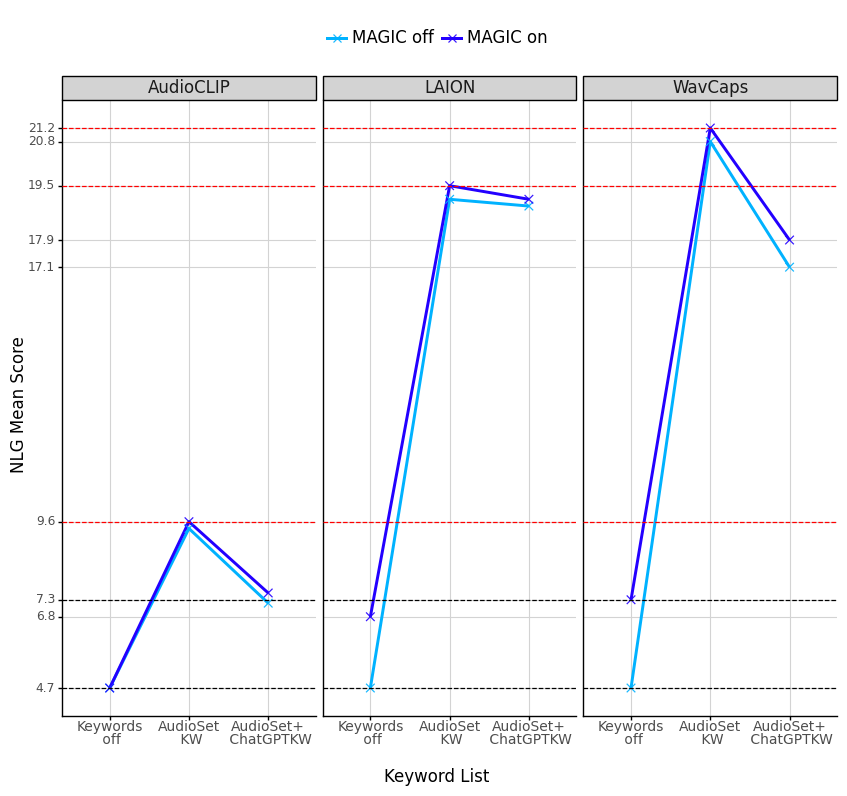

<ggplot: (8749255922545)>

In [44]:
# y_grid =  ablation_table["Score"]#.drop(index=2)
y_grid = pd.Series([4.7, 6.8, 7.3, 9.6, 17.1, 17.9, 19.5, 20.8, 21.2])

plot = (
    ggplot(ablation_table)
    + aes(x="Keywords", y="Score", color="MAGIC", group="MAGIC")
    # + facet_grid('Keywords ~ MAGIC')
    # + scale_color_gradient(low='blue', high='red', limits=(0.1, 0.16))
    + geom_line(size=1.2)
    + geom_point(size=3, alpha=0.9, shape="x")
    + geom_hline(
        max_values,
        aes(yintercept="Score"),
        color="red",
        show_legend=True,
        linetype="dashed",
    )
    + geom_hline(yintercept=7.3, color="black", linetype="dashed")
    + geom_hline(yintercept=4.7, color="black", linetype="dashed")
    + theme_classic()
    + facet_wrap("Audio_Model")
    # + facet_grid("~ Audio Model")
    # + scale_x_continuous(breaks=np.linspace(0, 2, 21))
    + scale_x_discrete(
        labels=["Keywords\n off", "AudioSet\n KW", "AudioSet+\n ChatGPTKW"]
    )
    + scale_y_continuous(breaks=y_grid)
    + scale_color_manual(values=["#00b2ff", "#2300ff"])
    + xlab("Keyword List")
    + ylab("NLG Mean Score")
    + scale_shape_manual(values=["x"])
)

plot += theme(
    figure_size=(10, 8),
    axis_text_x=element_text(size=10, margin={"t": 10}, angle=0, hjust=-1, vjust=0.95),
)

plot += theme(
    legend_title_align="center",
    legend_title=element_blank(),
    legend_text=element_text(size=12),
    strip_text_x=element_text(size=12),
    axis_title=element_text(size=12, margin={"t": 15}),
)
# axis_text=element_text(size=12))
# plot_title=element_text(text="Audio Model, Keyword List and MAGIC Ablation on the AudioCaps Test Set", size=18))


plot += theme(
    panel_grid_minor=element_blank(),
    panel_grid_major=element_line(color="lightgray"),
    strip_background=element_rect(fill="lightgray"),
    legend_position="top",
)

plot.save("../plots/AudioCaps_model_ablation.png", dpi=320)

plot